# Acknowledgements

Notebook developed by Andrew Ferguson for the UChicago course MENG15100: Machine Learning and Artificial Intelligence for Molecular Discovery and Engineering.

## Data

Let's start by importing some training data from a csv file using pandas.

We will start working with a simple data set with one input variable $x$ and one output variable $y$.

In [13]:
import pandas as pd

# Replace with the actual raw GitHub URL of your file
github_raw_url = 'https://raw.githubusercontent.com/andrewlferguson/MENG15100/main/notebooks/M3/linreg.csv'

# Load the data into a Pandas DataFrame
df = pd.read_csv(github_raw_url)

# Show the data
print(df)

           x          y
0   0.526316   2.039261
1   1.052632   4.926956
2   1.578947   7.993428
3   2.105263   5.794851
4   2.631579   7.110673
5   3.157895  12.053162
6   3.684211  11.745396
7   4.210526  10.587367
8   4.736842  13.927225
9   5.263158  13.231059
10  5.789474  14.542225
11  6.315789  17.273398
12  6.842105  14.278703
13  7.368421  15.971217
14  7.894737  19.612267
15  8.421053  20.026969
16  8.947368  23.996916
17  9.473684  22.868162


It is our goal to fit a linear regression model to these data of the form $y = \phi_0 + \phi_1 x$.

Recall that $\{\phi_0, \phi_1\}$ are the trainable parameters of our model, $x$ is the input data, and $y$ is the output data.

In this simple example, mainly to make plotting easy, the $x$ data are just one dimensional (i.e., there is a single $x$ feature associated with each of the 18 instances or in the training data).

# Human Learning

Now let's do some graphical exploration and "human learning" where we will guess the optimal values of the linear regression fitting parameters $\phi_0$ (intercept) and $\phi_1$ (slope).

We will use matplotlib to make an interactive plot.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider

# Load CSV data
x = df['x'].values
y = df['y'].values

# Define the interactive plot function
def plot_line(slope=2.0, intercept=1.0):
    y_line = slope * x + intercept

    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, color='blue', label='Data')
    plt.plot(x, y_line, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Interactive Linear Fit')
    plt.grid(True)
    plt.legend()
    plt.show()

# Sliders for slope and intercept
interact(
    plot_line,
    slope=FloatSlider(value=2.0, min=-10, max=10, step=0.2, description='Slope'),
    intercept=FloatSlider(value=1.0, min=-10, max=10, step=0.2, description='Intercept')
)


interactive(children=(FloatSlider(value=2.0, description='Slope', max=10.0, min=-10.0, step=0.2), FloatSlider(…

<function __main__.plot_line(slope=2.0, intercept=1.0)>

What appears to be a good choice for $\phi_0$ (intercept) and $\phi_1$ (slope)?

Enter them here:

In [27]:
phi_0_HUMAN = 0.0
phi_1_HUMAN = 0.0

# Machine Learning

OK, now let's let the machine do the work by asking it to find the $\boldsymbol\phi = \{\phi_0,\phi_1\}$ that minimize the least squares loss function $L[\boldsymbol\phi] = \sum_i (\hat y_i - y_i)^2$.

We recall that the loss function is the sum of square residuals: $y_i$ is the true value of $y$ in data instance $i$ and $\hat y_i = f(x_i) = \phi_0 + \phi_1 x_i$ is the prediction of our model.

The learning algorithm will optimize $\boldsymbol\phi = \{\phi_0,\phi_1\}$ by finding the lowest point on the loss lanscape $L[\boldsymbol\phi]$.

One way to find the minimum is by gradient descent and this is the method of choice for large machine learning problems. For linear regression, it turns out that there is a closed form analytical solution that we can use to get there more efficiently, but we wind up in the same place either way.

We will use scikit-learn (sklearn) to solve the problem for us.

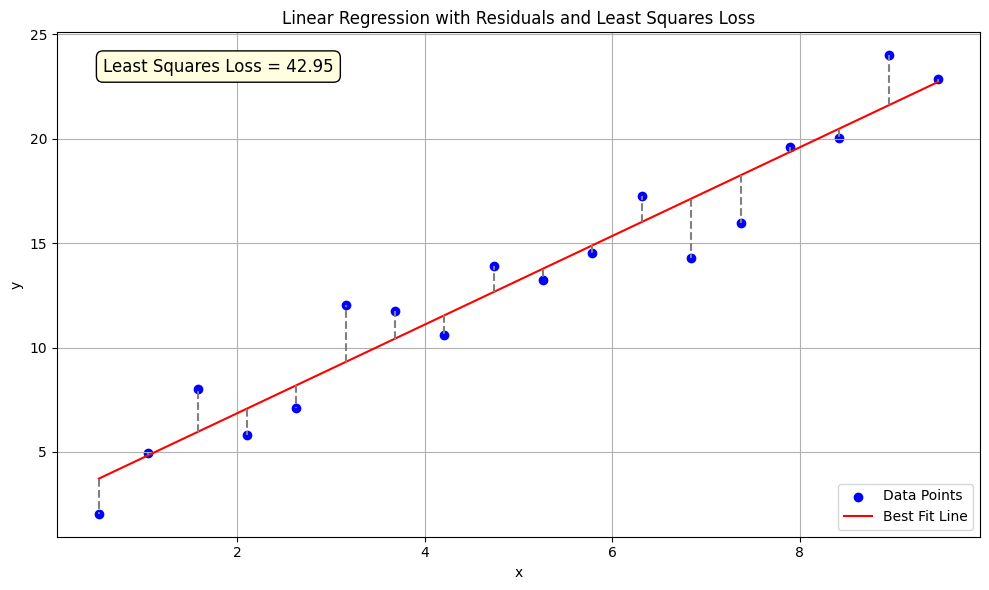

Best Fit Slope (phi_1): 2.12
Best Fit Intercept (phi_0): 2.61


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load CSV data
x = df['x'].values.reshape(-1, 1)
y = df['y'].values.reshape(-1, 1)

# Fit linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Get slope and intercept
slope = model.coef_[0]
intercept = model.intercept_

# Calculate residuals and loss
residuals = y - y_pred
squared_loss = np.sum(residuals**2)

# Plot data, best-fit line, and residuals
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data Points')
plt.plot(x, y_pred, color='red', label='Best Fit Line')

# Plot residuals
for xi, yi, ypi in zip(x, y, y_pred):
    plt.vlines(xi, ypi, yi, color='gray', linestyle='dashed')

# Annotate least squares loss
plt.text(0.05, 0.95, f'Least Squares Loss = {squared_loss:.2f}',
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='black'))

# Final touches
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression with Residuals and Least Squares Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Reporting out best fit slope and intercept
print(f"Best Fit Slope (phi_1): {slope[0]:.2f}")
print(f"Best Fit Intercept (phi_0): {intercept[0]:.2f}")

# Introducing nonlinearities

We will now consider a more interesting data set that exhibits a nonlinear relationship in $y = f(x)$ and that is therefore poorly fitted by a linear model $y = \phi_0 + \phi_1 x$.

Remarkably, we can use all of the tools of linear regression to make a nonlinear fit. How? We can trick the algorithm to operate on nonlinear features. We add nonlinearities not into the model, but ask a linear model to operate on nonlinear features.

## Example 1

In this first example case, we will stick to a 1D input variable $x$ and introduce nonlinearities by constucting additional features that are nonlinear versions of $x$.

We will allow different features to be turned on and off, and the most complex model will look like:

$y = \phi_0 + \phi_1 x + \phi_2 x^2 + \phi_3 x^3 + \phi_4 x^4 + \phi_5 \ln(x) + \phi_6 \sin(x) + \phi_7 \cos(x) $

In [39]:
# Install ipywidgets in Colab
!pip install ipywidgets --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Generate a nonlinear dataset ---
np.random.seed(0)
x = np.linspace(1, 10, 100)
y = 2 * x**2 - 3 * x + 4*np.sin(x) + np.random.normal(scale=5, size=len(x))  # Nonlinear function

df = pd.DataFrame({'x': x, 'y': y})

# --- Define available transformations ---
transformations = {
    'x': lambda x: x,
    'x^2': lambda x: x**2,
    'x^3': lambda x: x**3,
    'x^4': lambda x: x**4,
    'ln(x)': lambda x: np.log(x),
    'sin(x)': lambda x: np.sin(x),
    'cos(x)': lambda x: np.cos(x)
}

# --- Create checkboxes for each term ---
checkboxes = {
    name: widgets.Checkbox(value=(name in ['x']), description=name)
    for name in transformations
}

# --- Output area for plot ---
output = widgets.Output()

# --- Generate selected features matrix ---
def get_selected_features(x):
    features = []
    labels = []
    for name, func in transformations.items():
        if checkboxes[name].value:
            features.append(func(x))
            labels.append(name)
    if not features:
        return None, None
    X = np.vstack(features).T
    return X, labels

# --- Plotting and regression update function ---
def update_plot(change=None):
    with output:
        clear_output(wait=True)

        X, labels = get_selected_features(df['x'].values)
        if X is None:
            print("Please select at least one feature.")
            return

        y = df['y'].values

        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        residuals = y - y_pred
        loss = np.sum(residuals ** 2)

        # Sort for plotting smooth lines
        x_vals = df['x'].values
        sort_idx = np.argsort(x_vals)
        x_sorted = x_vals[sort_idx]
        y_pred_sorted = y_pred[sort_idx]

        # --- Plot ---
        plt.figure(figsize=(10, 6))
        plt.scatter(x_vals, y, color='blue', label='Data Points')
        plt.plot(x_sorted, y_pred_sorted, color='red', label='Model Fit')

        # Residuals
        for xi, yi, ypi in zip(x_vals, y, y_pred):
            plt.vlines(xi, yi, ypi, color='gray', linestyle='dashed')

        # Coefficient annotation
        coef_str = '\n'.join([f'{lbl} = {coef:.2f}' for lbl, coef in zip(labels, model.coef_)])
        plt.text(0.05, 0.95,
                 f'Intercept = {model.intercept_:.2f}\n' + coef_str + f'\nLoss = {loss:.2f}',
                 transform=plt.gca().transAxes,
                 fontsize=11,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='black'))

        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Custom Linear Regression with Nonlinear Data")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# --- Attach update listeners ---
for cb in checkboxes.values():
    cb.observe(update_plot, names='value')

# --- Display the GUI ---
selectors = widgets.VBox(list(checkboxes.values()))
display(widgets.HBox([selectors, output]))
update_plot()


## Example 2

In this second example case, we will consider a 2D input variable $\boldsymbol x = \{x_1,x_2\}$ and introduce nonlinearities by constucting additional features that are nonlinear versions of $x_1$ and $x_2$.

We will allow different features to be turned on and off, and the most complex model will look like:

$y = \phi_0 + \phi_1 x_1 + \phi_2 x_2 + \phi_3 x_1^2 + \phi_4 x_2^2 + \phi_5 x_1 x_2 + \phi_6 \sin(x_1) + \phi_7 \sin(x_2) + \phi_8 sin(x_1 x_2)$

Of course now we will need to make a 3D plot since we have one output variable $y$ and two input variables $x_1$ and $x_2$.

In [40]:
# Install ipywidgets in Colab
!pip install ipywidgets --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D

# --- Generate nonlinear 2D data ---
np.random.seed(0)
x1 = np.linspace(-3, 3, 30)
x2 = np.linspace(-3, 3, 30)
X1, X2 = np.meshgrid(x1, x2)
x1_flat = X1.flatten()
x2_flat = X2.flatten()

# True function (nonlinear)
y = 1.5 * x1_flat - 2.0 * x2_flat + 0.8 * x1_flat * x2_flat + np.sin(x1_flat) + np.random.normal(0, 1, x1_flat.shape[0])

df = pd.DataFrame({'x1': x1_flat, 'x2': x2_flat, 'y': y})

# --- Define transformations ---
transformations = {
    'x1': lambda x1, x2: x1,
    'x2': lambda x1, x2: x2,
    'x1^2': lambda x1, x2: x1**2,
    'x2^2': lambda x1, x2: x2**2,
    'x1*x2': lambda x1, x2: x1 * x2,
    'sin(x1)': lambda x1, x2: np.sin(x1),
    'sin(x2)': lambda x1, x2: np.sin(x2),
    'sin(x1*x2)': lambda x1, x2: np.sin(x1 * x2)
}

# --- Create checkboxes for terms ---
checkboxes = {
    name: widgets.Checkbox(value=(name in ['x1', 'x2']), description=name)
    for name in transformations
}

output = widgets.Output()

# --- Feature generation ---
def get_selected_features(x1, x2):
    features = []
    labels = []
    for name, func in transformations.items():
        if checkboxes[name].value:
            features.append(func(x1, x2))
            labels.append(name)
    if not features:
        return None, None
    X = np.vstack(features).T
    return X, labels

# --- Plotting and regression update ---
def update_plot(change=None):
    with output:
        clear_output(wait=True)

        x1_vals = df['x1'].values
        x2_vals = df['x2'].values
        y_vals = df['y'].values

        X, labels = get_selected_features(x1_vals, x2_vals)
        if X is None:
            print("Please select at least one feature.")
            return

        # Fit regression
        model = LinearRegression()
        model.fit(X, y_vals)
        y_pred = model.predict(X)
        residuals = y_vals - y_pred
        loss = np.sum(residuals ** 2)

        # For plotting surface
        x1_grid = np.linspace(-3, 3, 40)
        x2_grid = np.linspace(-3, 3, 40)
        X1g, X2g = np.meshgrid(x1_grid, x2_grid)
        X1g_flat = X1g.flatten()
        X2g_flat = X2g.flatten()

        X_grid, _ = get_selected_features(X1g_flat, X2g_flat)
        y_grid_pred = model.predict(X_grid).reshape(X1g.shape)

        # --- 3D Plot ---
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Surface
        ax.plot_surface(X1g, X2g, y_grid_pred, alpha=0.6, cmap='viridis', edgecolor='none')

        # Data points
        ax.scatter(x1_vals, x2_vals, y_vals, color='red', s=10, label='Data Points')

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('y')
        ax.set_title("3D Linear Regression Surface")

        # Coefficient display
        coef_str = '\n'.join([f'{lbl} = {coef:.2f}' for lbl, coef in zip(labels, model.coef_)])
        print(f'Intercept: {model.intercept_:.2f}')
        print(coef_str)
        print(f'Least Squares Loss: {loss:.2f}')

        plt.tight_layout()
        plt.show()

# --- Attach checkbox callbacks ---
for cb in checkboxes.values():
    cb.observe(update_plot, names='value')

# --- Display GUI ---
selectors = widgets.VBox(list(checkboxes.values()))
display(widgets.HBox([selectors, output]))
update_plot()


# Regularization

# Cross Validation

# Model Selection